In [118]:
import csv
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

folder_name = "data_files"
legend_filename = "_legend.csv"
file_extension = ".h5"

###############################################
# function to use for scaling image contrast
def scale(value, exposure_time_in_ms):
    # these are the min and max values recorded from the camera across all images
    global_min_value = 135790592
    global_max_value = 760741888
    
    # scaling factor per ms: increase this to brighten the images
    scaling_factor_per_ms = 0.1
    
    scale_min = global_min_value
    scale_max_per_ms = scaling_factor_per_ms * (global_max_value - global_min_value)
    return (value - scale_min) / (scale_max_per_ms * exposure_time_in_ms)

###############################################
# read the legend file with the list of files and metadata
with open(f'{folder_name}/{legend_filename}') as f:
    reader = csv.reader(f)
    legend = list(reader)

file_list = [
    { 'name': row[0],
      'exposure_time_in_ms': float(row[1]),
      'with_ion': row[2].upper() == 'Y' } for row in legend[1:]]
print(file_list)

###############################################
# read all the images and store them in all_images
all_images = { 'bright': {}, 'dark': {} }

for file in file_list:    
    f = h5py.File(f"{folder_name}/{file['name']}{file_extension}", 'r')

    ion_state = 'bright' if file['with_ion'] else 'dark'
    exposure_time_in_ms = file['exposure_time_in_ms']

    for datapoint_idx in range(1,10):
        try:
            datapoint = f["images"][f"datapoint{datapoint_idx}"]
        except:
            continue

        for image_idx in range(100):
            image_data = datapoint[str(image_idx)][()]
                  
            # scale image_data to range from 0 to 1
            #image_data = [[scale(value, exposure_time_in_ms) for value in row] for row in image_data]
                  
            if not exposure_time_in_ms in all_images[ion_state]:
                all_images[ion_state][exposure_time_in_ms] = []
            all_images[ion_state][exposure_time_in_ms].append(image_data)

[{'name': '1614_14_images', 'exposure_time_in_ms': 1.0, 'with_ion': False}, {'name': '1624_50_images', 'exposure_time_in_ms': 0.5, 'with_ion': False}, {'name': '1629_33_images', 'exposure_time_in_ms': 0.2, 'with_ion': False}, {'name': '1705_25_images', 'exposure_time_in_ms': 0.2, 'with_ion': True}, {'name': '1712_39_images', 'exposure_time_in_ms': 0.5, 'with_ion': True}, {'name': '1714_40_images', 'exposure_time_in_ms': 1.0, 'with_ion': True}, {'name': '1716_40_images', 'exposure_time_in_ms': 2.0, 'with_ion': True}, {'name': '1718_41_images', 'exposure_time_in_ms': 3.0, 'with_ion': True}, {'name': '1721_21_images', 'exposure_time_in_ms': 4.0, 'with_ion': True}, {'name': '1725_22_images', 'exposure_time_in_ms': 6.0, 'with_ion': True}, {'name': '1732_27_images', 'exposure_time_in_ms': 6.0, 'with_ion': False}, {'name': '1734_15_images', 'exposure_time_in_ms': 4.0, 'with_ion': False}, {'name': '1736_03_images', 'exposure_time_in_ms': 2.0, 'with_ion': False}, {'name': '1738_41_images', 'exp

## a couple of sample images

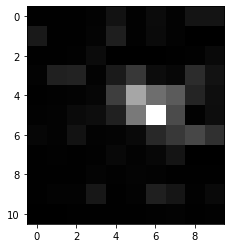

In [119]:
# gets the 14th sample bright image with exposure_time_in_ms=2
sample_bright = all_images['bright'][4][14]
#print(np.round(sample_bright,3))
plt.figure()
plt.imshow(sample_bright, cmap=plt.get_cmap('gray'), vmin=137691136.0, vmax=533921792)

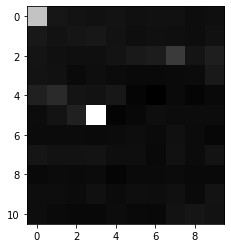

In [120]:
# gets the 14th sample dark image with exposure_time_in_ms=2
sample_dark = all_images['dark'][2][899]
#print(np.round(sample_dark,3))
plt.figure()
plt.imshow(sample_dark, cmap=plt.get_cmap('gray'), vmin=136708096.0, vmax=176160768)

In [121]:
np.amin(sample_dark)

136708096

## histogram plot of indidual/all pixels of all dark/bright images

failed to fit for row 5, col 0
failed to fit for row 5, col 1
failed to fit for row 5, col 2
failed to fit for row 5, col 3
failed to fit for row 5, col 4
failed to fit for row 5, col 5
failed to fit for row 5, col 6
failed to fit for row 5, col 7
failed to fit for row 5, col 8
failed to fit for row 5, col 9


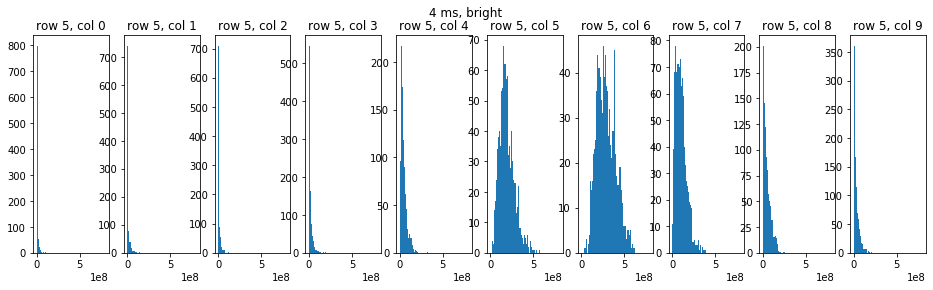

In [182]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.special import gamma
import math

def fit_function_poisson(x, A, lamb, b):
    bx = np.multiply(b, x)
    return A*np.exp(-lamb)*(lamb**(bx)/gamma(bx+1))

def fit_function_gaussian(x, A, x0, sigma):
    return np.multiply(A, np.exp(-(np.subtract(x, x0))**2 / (2 * sigma**2)))

def fit_function_poisson_gaussian_sum(x, A_poisson, lamb, b): #, A_gaussian, x0, sigma):
    A_gaussian = 122.61271136259133
    x0 = 2492545.215280129
    sigma = 862329.7365410712
    return np.add(fit_function_poisson(x, A_poisson, lamb, b), fit_function_gaussian(x, A_gaussian, x0, sigma))

def fit_function_poisson_gaussian_convolve(x, A_poisson, lamb, b): #, A_gaussian, x0, sigma):
    A_gaussian = 122.61271136259133
    x0 = 2492545.215280129
    sigma = 862329.7365410712
    return np.convolve(fit_function_poisson(x, A_poisson, lamb, b), fit_function_gaussian(x, A_gaussian, x0, sigma))

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(16,4))
exposure_time_in_ms = 4
row = 5
#for row in range(4,7):
for col in range(0, 10): 
    one_pixel_bright = [image[row][col] - np.amin(sample_dark) for image in all_images['bright'][exposure_time_in_ms]]
    y,x,_ = axes[col].hist(np.array(one_pixel_bright).ravel(),bins=64, range=(0,8e8)) #range=(136904704,152891904));
    x1 = [(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)]

    initial_guess_poisson = [500,5, 5/0.3e8]
    #initial_guess_gaussian = [100, 0.25e7, 0.1e7]
    try:
        popt, pcov = curve_fit(fit_function_poisson_gaussian_convolve, x1, y, p0=initial_guess_poisson, bounds=(-np.inf, np.inf))
        axes[col].plot(x1, fit_function_poisson_gaussian_convolve(x1, *popt))
        print(*popt)
        print(f'lambda={popt[1]} for row {row}, col {col}')
    except:
        print(f'failed to fit for row {row}, col {col}')

    #axes[col].plot(np.linspace(0,152891904,10000),[fit_function_poisson(x,*initial_guess_poisson) for x in np.linspace(0,152891904,10000)],'k--', label='initial guess', lw=2)
    #axes[col].plot(x1,[fit_function_poisson(x,*initial_guess_poisson) for x in x1],'k--', label='initial guess', lw=2)

    axes[col].set_title(f'row {row}, col {col}')
plt.suptitle(f'{exposure_time_in_ms} ms, bright')
plt.show()



In [181]:
x1[np.argmax(y)]


6250000.0

## lambda vs t_exp for particular pixel distribution

No handles with labels found to put in legend.
No handles with labels found to put in legend.


popt1 = [ 1.0722027  -0.39364865]
popt2 = [ 1.21058108 -0.24445946]
popt3 = [1.13763514 0.15256757]
popt4 = [1.5177027  0.23135135]


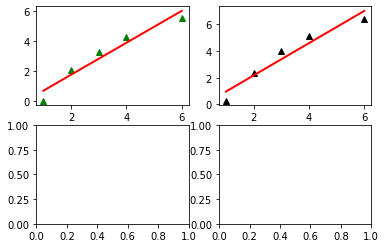

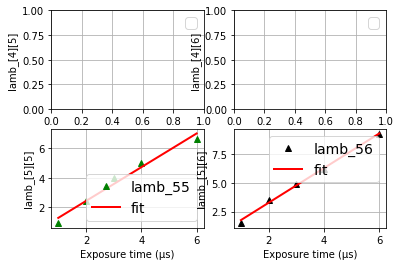

In [170]:
# linear fitting of lambda

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

t_exp = [1, 2, 3, 4, 6]
lamb_45 = [0.007, 2.05, 3.28, 4.29, 5.56]
lamb_46 = [0.277, 2.33, 3.99, 5.11, 6.44]
lamb_55 = [0.925, 2.40, 4, 5.02, 6.62]
lamb_56 = [1.47, 3.55, 4.94, 6.20, 9.28]


xdata = t_exp


def linear(x, m, c):
    return np.multiply(m, x) + c

initial_guess = [1, 1]

popt1, pcov = curve_fit(linear, xdata, lamb_45, p0=initial_guess, bounds=(-np.inf, np.inf))
popt2, pcov = curve_fit(linear, xdata, lamb_46, p0=initial_guess, bounds=(-np.inf, np.inf))
popt3, pcov = curve_fit(linear, xdata, lamb_55, p0=initial_guess, bounds=(-np.inf, np.inf))
popt4, pcov = curve_fit(linear, xdata, lamb_56, p0=initial_guess, bounds=(-np.inf, np.inf))

fig, ax = plt.subplots(2, 2)#, figsize=(16,6))
ax[0,0].plot(t_exp,lamb_45,'g^',label="lamb_45", lw=2)
ax[0,0].plot(xdata, linear(xdata, *popt1),label='fit',linestyle='-', linewidth=2, color='red')
ax[0,1].plot(t_exp,lamb_46,'k^',label="lamb_46", lw=2)
ax[0,1].plot(xdata, linear(xdata, *popt2),label='fit',linestyle='-', linewidth=2, color='red')

fig, ax = plt.subplots(2, 2)#, figsize=(16,4))
ax[1,0].plot(t_exp,lamb_55,'g^',label="lamb_55", lw=2)
ax[1,0].plot(xdata, linear(xdata, *popt3),label='fit',linestyle='-', linewidth=2, color='red')
ax[1,1].plot(t_exp,lamb_56,'k^',label="lamb_56", lw=2)
ax[1,1].plot(xdata, linear(xdata, *popt4),label='fit',linestyle='-', linewidth=2, color='red')

ax[0,0].set_xlabel('Exposure time (μs)')
ax[0,0].set_ylabel('lamb_[4][5]')
ax[0,1].set_xlabel('Exposure time (μs)')
ax[0,1].set_ylabel('lamb_[4][6]')

ax[1,0].set_xlabel('Exposure time (μs)')
ax[1,0].set_ylabel('lamb_[5][5]')
ax[1,1].set_xlabel('Exposure time (μs)')
ax[1,1].set_ylabel('lamb_[5][6]')

print('popt1 =', popt1)
print('popt2 =', popt2)
print('popt3 =', popt3)
print('popt4 =', popt4)
ax[0,0].grid('True')
ax[1,1].grid('True')
ax[0,1].grid('True')
ax[1,0].grid('True')
ax[0,0].legend(fontsize=14)
ax[1,0].legend(fontsize=14)
ax[0,1].legend(fontsize=14)
ax[1,1].legend(fontsize=14)
plt.show()


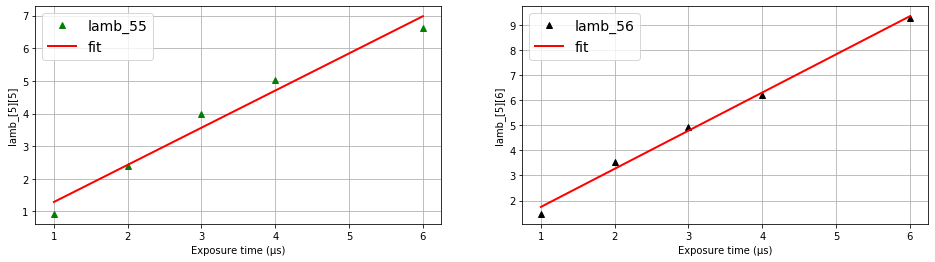

In [173]:
fig, ax = plt.subplots(1, 2, figsize=(16,4))
ax[0].plot(t_exp,lamb_55,'g^',label="lamb_55", lw=2)
ax[0].plot(xdata, linear(xdata, *popt3),label='fit',linestyle='-', linewidth=2, color='red')
ax[1].plot(t_exp,lamb_56,'k^',label="lamb_56", lw=2)
ax[1].plot(xdata, linear(xdata, *popt4),label='fit',linestyle='-', linewidth=2, color='red')

ax[0].set_xlabel('Exposure time (μs)')
ax[0].set_ylabel('lamb_[5][5]')
ax[1].set_xlabel('Exposure time (μs)')
ax[1].set_ylabel('lamb_[5][6]')

ax[0].grid('True')
ax[1].grid('True')

ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)

plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,4))
exposure_time_in_ms = 2
row = 4
for col in range(0, 5): 
    one_pixel_dark = [image[row][col] - np.amin(sample_dark) for image in all_images['dark'][exposure_time_in_ms]]
    y1,x2,_ = axes[col].hist(np.array(one_pixel_dark).ravel(),bins=64, range=(0,0.2e8), color='g');
    x3 = [(x2[i] + x2[i+1]) / 2 for i in range(len(x2) - 1)]

    initial_guess_poisson =  [500,5, 5/0.03e8]
    initial_guess_gaussian = [100, 0.25e7, 0.1e7]
    popt, pcov = curve_fit(fit_function_gaussian, x3, y1, p0=initial_guess_gaussian, bounds=(-np.inf, np.inf))
    
    axes[col].plot(x3, fit_function_gaussian(x3, *popt))
    #axes[col].plot(np.linspace(0,152891904,10000),[fit_function_poisson(x,*initial_guess_poisson) for x in np.linspace(0,152891904,10000)],'k--', label='initial guess', lw=2)
    
    #plt.plot(xdata,fit_function_poisson(xdata,*popt),'b--', label='poisson', lw=2)
    
    axes[col].set_title(f'row {row}, col {col}')
    print(*popt)
    #print(f'lambda={popt[1]} for row {row}, col {col}')
plt.suptitle(f'{exposure_time_in_ms} ms, dark')
plt.show()

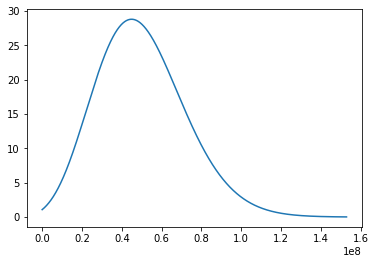

In [8]:
initial_guess_poisson = [160, 5, 1/1e7]
plt.plot(np.linspace(0,152891904,10000),[fit_function_poisson(x,*initial_guess_poisson) for x in np.linspace(0,152891904,10000)])

In [82]:
np.amax(one_pixel_bright)

89260032

In [66]:
np.subtract(136249344,621281280)/1592

-304668.30150753766

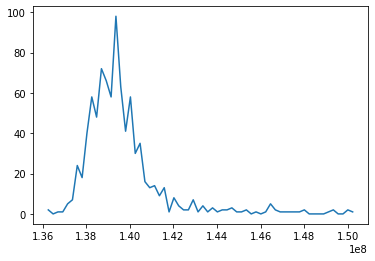

In [67]:
x1 = [(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)]
plt.plot(x1,y)

popt_Gaussian =  [7.29296086e+01 1.39163398e+08 9.57835328e+05]
pcov =  [2.70242619e+00 4.09801725e+04 4.09963459e+04]


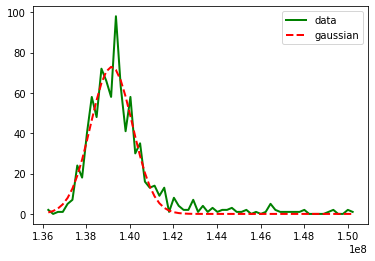

In [68]:
## Poisson distribution fitting

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.special import gamma
import math

def fit_function_gaussian(x, A, x0, sigma):
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2))

# def fit_function_poisson(x, A, lamb, b):
#     #return poisson.pmf(x, lamb)
    
#     bx = np.multiply(b, x)
# #     return np.multiply(a, np.exp(-lamb)*(lamb**(bx)/gamma(bx+1)))
#     return A*np.exp(-lamb)*(lamb**(bx)/gamma(bx+1))

xdata = x1
ydata = y

initial_guess_gaussian = [80, 138249344, 10000000]
#initial_guess_poisson = [140, 0.001, 0.5/2e9]

plt.figure(figsize=(6,4))
plt.plot(xdata,ydata,'g-', label='data', lw=2)

popt, pcov = curve_fit(fit_function_gaussian, xdata, ydata, p0=initial_guess_gaussian, bounds=(-np.inf, np.inf))
plt.plot(xdata,fit_function_gaussian(xdata,*popt),'r--', label='gaussian', lw=2)

# popt, pcov = curve_fit(fit_function_poisson, xdata, ydata, p0=initial_guess_poisson, bounds=(-np.inf, np.inf))
# plt.plot(xdata,fit_function_poisson(xdata,*popt),'b--', label='poisson', lw=2)
# plt.plot(xdata,[fit_function_poisson(x,*initial_guess_poisson) for x in xdata],'k--', label='initial guess', lw=2)


print('popt_Gaussian = ', popt)
#stdev
print('pcov = ', np.sqrt(np.diag(pcov)))

plt.legend(fontsize=10)
plt.show()

## mean/std of indidual/all pixels and histogram plot

mean(pixel_means) =  139731490.13333333
std(pixel_means) =  0.0
mean(pixel_stds) =  4222016.326038109


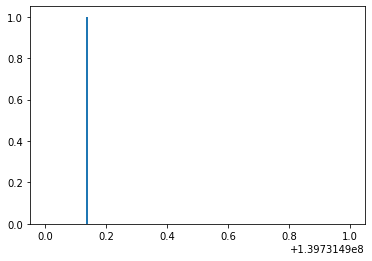

In [46]:
print('mean(pixel_means) = ', np.mean(pixel_means))
print('std(pixel_means) = ', np.std(pixel_means))
print('mean(pixel_stds) = ', np.mean(pixel_stds))
plt.hist(pixel_means, bins=128, range=(139731490,139731491)); #plotting histogram of means

In [45]:
np.amin(pixel_means)

139731490.13333333

## linear fitting of pixel_means with exposure time

popt = [3.37861410e+05 1.38971402e+08]


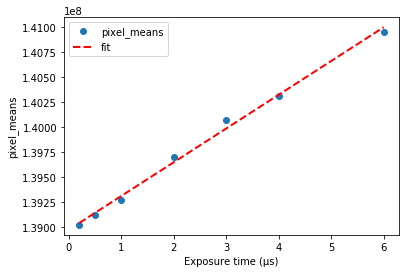

In [12]:
# linear fitting of pixel_means

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

t_exp = [0.2, 0.5, 1, 2, 3, 4, 6]
pixel_means = [139019583, 139117643, 139266860, 139702254, 140067619, 140313279, 140954861]
pixel_stds = [2341497, 2901283, 3561775, 4671834, 5499061, 6199272, 7406310]

def linear(x, m, c):
    return np.multiply(m, x) + c

xdata = t_exp
ydata = pixel_means

initial_guess = [1, 139019583]

popt, pcov = curve_fit(linear, xdata, ydata, p0=initial_guess, bounds=(-np.inf, np.inf))


plt.figure(figsize=(6, 4))
plt.plot(t_exp, pixel_means, 'o', label='pixel_means', lw=2)
plt.plot(xdata, linear(xdata,*popt),'r--', label='fit', lw=2)

plt.xlabel('Exposure time (μs)')
plt.ylabel('pixel_means')

print('popt =', popt)

plt.legend(fontsize=10)
plt.show()

## linear fitting of pixel_stds with exposure time

popt = [ 863089.39229215 2595348.44855276]


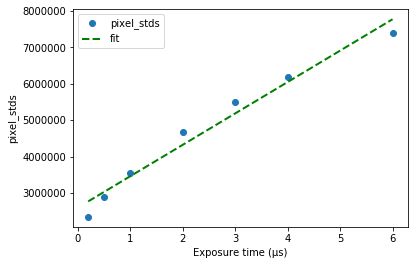

In [13]:
# linear fitting of pixel_stds

def linear(x, m, c):
    return np.multiply(m, x) + c

xdata = t_exp
ydata = pixel_stds

initial_guess = [1, 2341497]

popt, pcov = curve_fit(linear, xdata, ydata, p0=initial_guess, bounds=(-np.inf, np.inf))

plt.figure(figsize=(6, 4))
plt.plot(t_exp, pixel_stds, 'o', label='pixel_stds', lw=2)
plt.plot(xdata, linear(xdata,*popt),'g--', label='fit', lw=2)
plt.xlabel('Exposure time (μs)')
plt.ylabel('pixel_stds')

print('popt =', popt)

plt.legend(fontsize=10)
plt.show()

In [14]:
np.amax(pixel_means)

140954861

## histogram plot of indidual/all pixels of all bright images

Text(0.5, 0.98, 'Exposure time = 2ms')

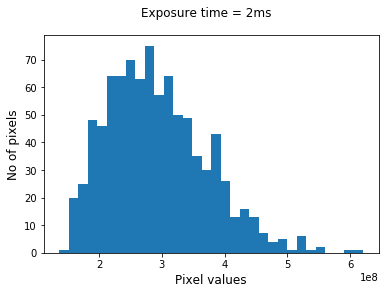

In [75]:
pixel_means = []
pixel_stds = []
for i in range(5,6): # range(0, 11): [4,5,6]
    for j in range(6,7): # range(0, 10):[5,6,7]
        one_pixel = [image[i][j] for image in all_images['bright'][2]]
        pixel_means.append(np.mean(one_pixel))
        pixel_stds.append(np.std(one_pixel))
        
        #bright images
        y, x,_ = plt.hist(np.array(one_pixel).ravel(),bins=32, range=(136249344,621281280)); 

plt.xlabel("Pixel values", fontsize=12)
plt.ylabel("No of pixels", fontsize=12)
plt.suptitle('Exposure time = 2ms', fontsize=12)

In [76]:
np.amin(one_pixel)

147062784

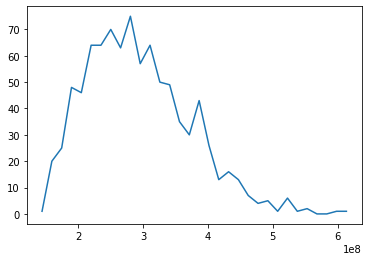

In [77]:
x1 = [(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)]
plt.plot(x1,y)

popt_poisson =  [6.05516670e+02 1.23046927e+01 4.35273375e-08]
pcov =  [4.01904639e+01 9.98014031e-01 3.53909608e-09]


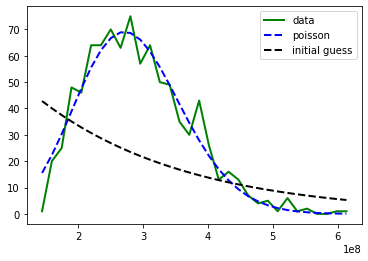

In [79]:
## Poisson distribution fitting

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.special import gamma
import math

def fit_function_poisson(x, A, lamb, b):
    #return poisson.pmf(x, lamb)
    
    bx = np.multiply(b, x)
#     return np.multiply(a, np.exp(-lamb)*(lamb**(bx)/gamma(bx+1)))
    return A*np.exp(-lamb)*(lamb**(bx)/gamma(bx+1))

xdata = x1
ydata = y

initial_guess_poisson = [80, 0.0001, 1/2e9]

plt.figure(figsize=(6,4))
plt.plot(xdata,ydata,'g-', label='data', lw=2)

popt, pcov = curve_fit(fit_function_poisson, xdata, ydata, p0=initial_guess_poisson, bounds=(-np.inf, np.inf))
plt.plot(xdata,fit_function_poisson(xdata,*popt),'b--', label='poisson', lw=2)
plt.plot(xdata,[fit_function_poisson(x,*initial_guess_poisson) for x in xdata],'k--', label='initial guess', lw=2)


print('popt_poisson = ', popt)
#stdev
print('pcov = ', np.sqrt(np.diag(pcov)))

plt.legend(fontsize=10)
plt.show()

mean(pixel_means) =  292141356.37333333
std(pixel_means) =  0.0
mean(pixel_stds) =  79364371.39954464


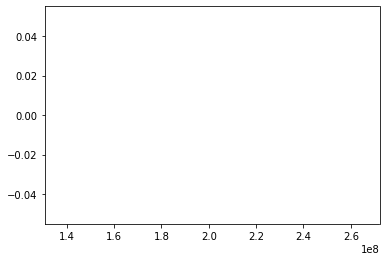

In [366]:
print('mean(pixel_means) = ', np.mean(pixel_means))
print('std(pixel_means) = ', np.std(pixel_means))
print('mean(pixel_stds) = ', np.mean(pixel_stds))
plt.hist(pixel_means, bins=128, range=(137101312,265682944)); #plotting histogram of means

In [364]:
np.amin(one_pixel)

147062784

In [331]:
q = [4,5,6]
print(list(q))

[4, 5, 6]


## plotting histogram of all dark images

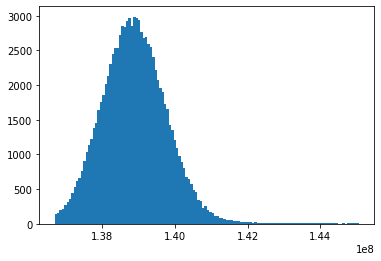

In [51]:
y, x,_ = plt.hist(np.array(all_images['dark'][0.2]).ravel(),bins=128, range=(136708096,145060768));
#y3, x3,_ = plt.hist(np.array(all_images['dark'][2]).ravel(),bins=128, range=(136908096,145060768));
#y2, x2,_ = plt.hist(np.array(all_images['dark'][6]).ravel(),bins=128, range=(136708096,145060768));


In [52]:
x1 = [(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)]
len(x1)


128

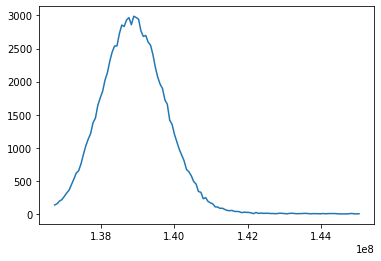

In [53]:
plt.plot(x1,y)

## fitting histogram plot with Gaussian

popt_gau =  [2.94065769e+03 1.38858605e+08 8.64403671e+05]
pcov =  [   7.544915   2558.80070789 2580.0312486 ]


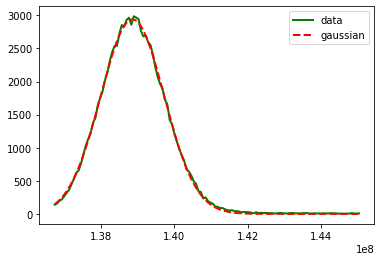

In [54]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.special import gamma
import math

def fit_function_gaussian(x, B, x0, sigma):
    return B * np.exp(-(x - x0)**2 / (2 * sigma**2))

def fit_function_poisson(x, A, lamb, b):
    #return poisson.pmf(x, lamb)
    
    bx = np.multiply(b, x)
#     return np.multiply(a, np.exp(-lamb)*(lamb**(bx)/gamma(bx+1)))
    return A*np.exp(-lamb)*(lamb**(bx)/gamma(bx+1))

xdata = x1
ydata = y

initial_guess_gaussian = [3000,1.38e8, 1e6]
initial_guess_poisson = [3000, 0.0001, 1/2e9]

plt.figure(figsize=(6,4))
plt.plot(xdata,ydata,'g-', label='data', lw=2)

popt, pcov = curve_fit(fit_function_gaussian, xdata, ydata, p0=initial_guess_gaussian, bounds=(-np.inf, np.inf))
plt.plot(xdata,fit_function_gaussian(xdata,*popt),'r--', label='gaussian', lw=2)
#plt.plot(xdata,[fit_function_gaussian(x,*initial_guess_gaussian) for x in xdata],'b--', label='initial guess', lw=2)


print('popt_gau = ', popt)
#stdev
print('pcov = ', np.sqrt(np.diag(pcov)))

#popt, pcov = curve_fit(fit_function_poisson, xdata, ydata, p0=initial_guess_poisson, bounds=(-np.inf, np.inf))
#plt.plot(xdata,fit_function_poisson(xdata,*popt),'b--', label='poisson', lw=2)
#plt.plot(np.linspace(0,1e9,10000),[fit_function_poisson(x,*initial_guess_poisson) for x in np.linspace(0,1e9,10000)],'k--', label='initial guess', lw=2)

#print(popt)
#print(pcov)
#print(np.sqrt(np.diag(pcov)))

plt.legend(fontsize=10)
plt.show()

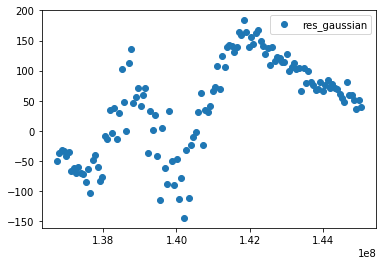

In [9]:
res_gau = ydata - fit_function_gaussian(xdata,*popt)
plt.figure()
plt.plot(xdata, res_gau,'o', label='res_gaussian', lw=2)
#plt.plot(xdata,res_poi,'^', label='res_poisson', lw=2)
# print(res_gau)
# print(ydata)

plt.legend(fontsize=10)
plt.show()

## linear fitting of mean and sigma of Gaussian distribution fitting at each exposure time

popt = [6.99707848e+04 1.38858162e+08]


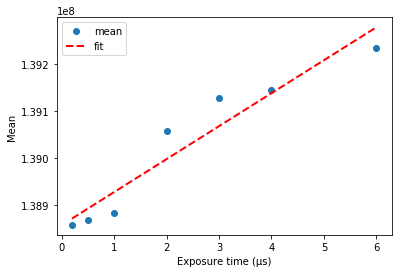

In [43]:
# linear fitting of mean

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

t_exp = [0.2, 0.5, 1, 2, 3, 4, 6]
mean = [138858605, 138869775, 138883125, 139058299, 139127408, 139144743, 139233689]
sigma = [864403.671, 870140.211, 877407.22, 888718.849, 917632.867, 924773.005, 961088.532]

def linear(x, m, c):
    return np.multiply(m, x) + c

xdata = t_exp
ydata = mean

initial_guess = [1, 138858600]

popt, pcov = curve_fit(linear, xdata, ydata, p0=initial_guess, bounds=(-np.inf, np.inf))


plt.figure(figsize=(6, 4))
plt.plot(t_exp, mean, 'o', label='mean', lw=2)
plt.plot(xdata, linear(xdata,*popt),'r--', label='fit', lw=2)

plt.xlabel('Exposure time (μs)')
plt.ylabel('Mean')

print('popt =', popt)

plt.legend(fontsize=10)
plt.show()

popt = [ 16688.33457722 860781.30965149]


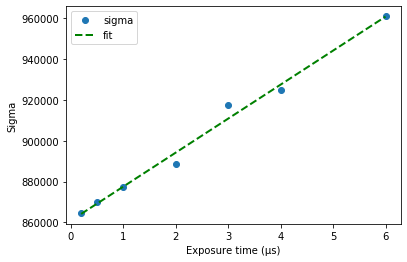

In [44]:
# linear fitting of sigma

def linear(x, m, c):
    return np.multiply(m, x) + c

xdata = t_exp
ydata = sigma

initial_guess = [1, 864403]

popt, pcov = curve_fit(linear, xdata, ydata, p0=initial_guess, bounds=(-np.inf, np.inf))

plt.figure(figsize=(6, 4))
plt.plot(t_exp, sigma, 'o', label='sigma', lw=2)
plt.plot(xdata, linear(xdata,*popt),'g--', label='fit', lw=2)
plt.xlabel('Exposure time (μs)')
plt.ylabel('Sigma')

print('popt =', popt)

plt.legend(fontsize=10)
plt.show()

## subtracting mean-offset and fitting Poisson distribution

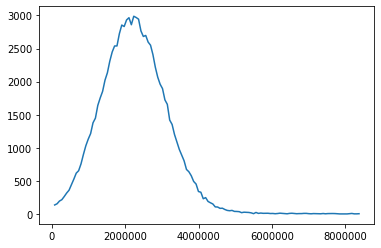

In [55]:
## subtracting mean-offset 
x11 = np.subtract(x1, 138858162-2200000)
plt.plot(x11, y)

## fitting Poisson distribution

popt_poi =  [1.92641783e+04 6.93812632e+00 3.03485544e-06]
pcov =  [1.96567486e+02 8.33816521e-02 3.70997915e-08]


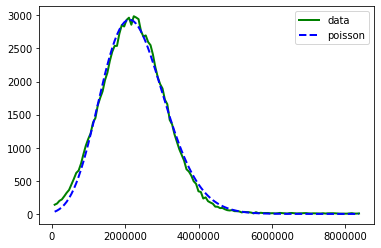

In [56]:
## Poisson distribution fitting

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.special import gamma
import math

def fit_function_poisson(x, A, lamb, b):
    #return poisson.pmf(x, lamb)
    
    bx = np.multiply(b, x)
#     return np.multiply(a, np.exp(-lamb)*(lamb**(bx)/gamma(bx+1)))
    return A*np.exp(-lamb)*(lamb**(bx)/gamma(bx+1))

xdata = x11
ydata = y

initial_guess_poisson = [3000, 0.0001, 1/2e9]

plt.figure(figsize=(6,4))
plt.plot(xdata,ydata,'g-', label='data', lw=2)

popt, pcov = curve_fit(fit_function_poisson, xdata, ydata, p0=initial_guess_poisson, bounds=(-np.inf, np.inf))
plt.plot(xdata,fit_function_poisson(xdata,*popt),'b--', label='poisson', lw=2)
#plt.plot(xdata,[fit_function_poisson(x,*initial_guess_poisson) for x in xdata],'k--', label='initial guess', lw=2)


print('popt_poi = ', popt)
#stdev
print('pcov = ', np.sqrt(np.diag(pcov)))

plt.legend(fontsize=10)
plt.show()

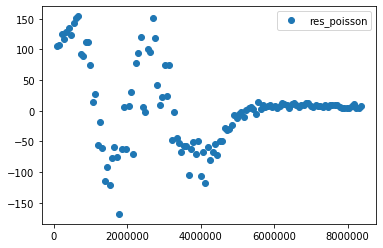

In [57]:
res_poi = ydata - fit_function_poisson(xdata,*popt)
plt.figure()
plt.plot(xdata, res_poi,'o', label='res_poisson', lw=2)
plt.legend(fontsize=10)
plt.show()

## scaling lambda parameter with exposure time for all dark images

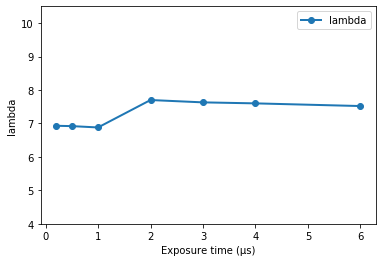

In [58]:
t_exp = [0.2, 0.5, 1, 2, 3, 4, 6]
lamb = [6.93, 6.92, 6.88, 7.70, 7.63, 7.60, 7.52]

plt.ylim(4,10.5)
plt.plot(t_exp, lamb, 'o-', label = 'lambda', lw = 2)

plt.xlabel('Exposure time (μs)')
plt.ylabel('lambda')

plt.legend(fontsize=10)
plt.show()


## plotting histogram of all bright images

In [60]:
np.amax(sample_bright)

533921792

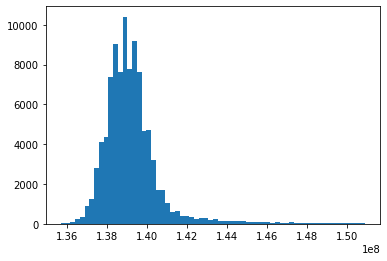

In [134]:
y1, x2,_ = plt.hist(np.array(all_images['bright'][0.2]).ravel(),bins=64, range=(135691136,150921792));
#y3, x3,_ = plt.hist(np.array(all_images['dark'][2]).ravel(),bins=128, range=(136908096,145060768));
#y2, x2,_ = plt.hist(np.array(all_images['dark'][6]).ravel(),bins=128, range=(136708096,145060768));


In [135]:
x3 = [(x2[i] + x2[i+1]) / 2 for i in range(len(x2) - 1)]
len(x3)


64

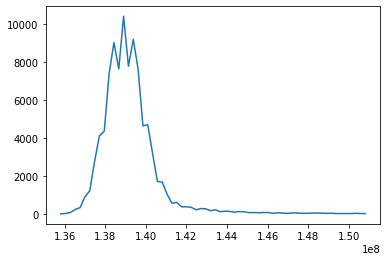

In [136]:
plt.plot(x3,y1)

popt_gau =  [9.34548155e+03 1.38947035e+08 9.28398642e+05]
pcov =  [  199.13300013 22842.30162094 22843.40455479]


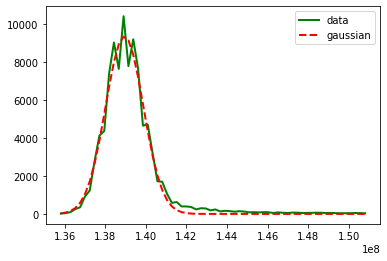

In [137]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.special import gamma
import math

def fit_function_gaussian(x, B, x0, sigma):
    return B * np.exp(-(x - x0)**2 / (2 * sigma**2))

def fit_function_poisson(x, A, lamb, b):
    #return poisson.pmf(x, lamb)
    
    bx = np.multiply(b, x)
#     return np.multiply(a, np.exp(-lamb)*(lamb**(bx)/gamma(bx+1)))
    return A*np.exp(-lamb)*(lamb**(bx)/gamma(bx+1))

xdata = x3
ydata = y1

initial_guess_gaussian = [4000,1.38e8, 1e6]
initial_guess_poisson = [3000, 0.0001, 1/2e9]

plt.figure(figsize=(6,4))
plt.plot(xdata,ydata,'g-', label='data', lw=2)

popt, pcov = curve_fit(fit_function_gaussian, xdata, ydata, p0=initial_guess_gaussian, bounds=(-np.inf, np.inf))
plt.plot(xdata,fit_function_gaussian(xdata,*popt),'r--', label='gaussian', lw=2)
#plt.plot(xdata,[fit_function_gaussian(x,*initial_guess_gaussian) for x in xdata],'b--', label='initial guess', lw=2)


print('popt_gau = ', popt)
#stdev
print('pcov = ', np.sqrt(np.diag(pcov)))

#popt, pcov = curve_fit(fit_function_poisson, xdata, ydata, p0=initial_guess_poisson, bounds=(-np.inf, np.inf))
#plt.plot(xdata,fit_function_poisson(xdata,*popt),'b--', label='poisson', lw=2)
#plt.plot(np.linspace(0,1e9,10000),[fit_function_poisson(x,*initial_guess_poisson) for x in np.linspace(0,1e9,10000)],'k--', label='initial guess', lw=2)

#print(popt)
#print(pcov)
#print(np.sqrt(np.diag(pcov)))

plt.legend(fontsize=10)
plt.show()

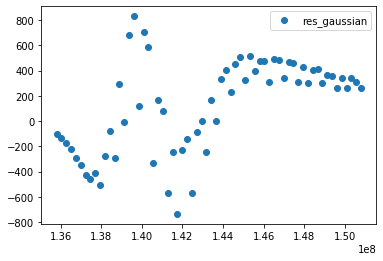

In [116]:
res_gau = ydata - fit_function_gaussian(xdata,*popt)
plt.figure()
plt.plot(xdata, res_gau,'o', label='res_gaussian', lw=2)
#plt.plot(xdata,res_poi,'^', label='res_poisson', lw=2)
# print(res_gau)
# print(ydata)

plt.legend(fontsize=10)
plt.show()

## linear fitting of mean and sigma of Gaussian distribution fitting at each exposure time


popt = [3.16991808e+05 1.38950657e+08]


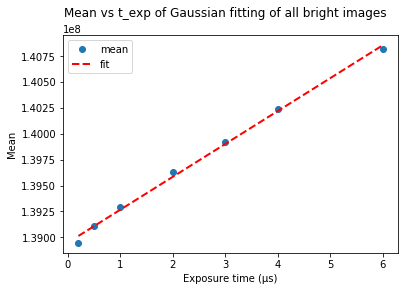

In [131]:
# linear fitting of mean

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

t_exp = [0.2, 0.5, 1, 2, 3, 4, 6]
mean_bright = [138947035, 139106910, 139291543, 139630708, 139919573, 140240375, 140812221]
sigma_bright = [928398, 982766, 1084347, 1243114, 1409331, 1596543, 1982873]

def linear(x, m, c):
    return np.multiply(m, x) + c

xdata = t_exp
ydata = mean_bright

initial_guess = [0.5, 138947035]

popt, pcov = curve_fit(linear, xdata, ydata, p0=initial_guess, bounds=(-np.inf, np.inf))


plt.figure(figsize=(6, 4))
plt.plot(t_exp, mean_bright, 'o', label='mean', lw=2)
plt.plot(xdata, linear(xdata,*popt),'r--', label='fit', lw=2)


plt.xlabel('Exposure time (μs)')
plt.ylabel('Mean')

print('popt =', popt)

plt.suptitle('Mean vs t_exp of Gaussian fitting of all bright images', fontsize=12)

plt.legend(fontsize=10)
plt.show()

popt = [179411.10406539 890172.36603435]


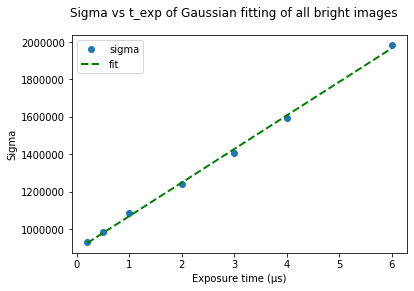

In [133]:
# linear fitting of sigma

def linear(x, m, c):
    return np.multiply(m, x) + c

xdata = t_exp
ydata = sigma_bright

initial_guess = [1, 864403]

popt, pcov = curve_fit(linear, xdata, ydata, p0=initial_guess, bounds=(-np.inf, np.inf))

plt.figure(figsize=(6, 4))
plt.plot(t_exp, sigma_bright, 'o', label='sigma', lw=2)
plt.plot(xdata, linear(xdata,*popt),'g--', label='fit', lw=2)
plt.xlabel('Exposure time (μs)')
plt.ylabel('Sigma')

print('popt =', popt)

plt.suptitle('Sigma vs t_exp of Gaussian fitting of all bright images', fontsize=12)

plt.legend(fontsize=10)
plt.show()